Search 1 | BE2 = -10.0 MeV, Lambda = (0.8469812724411141+0j)
Search 2 | BE2 = -5.0 MeV, Lambda = (1.0745902033729913+0j)
Search 3 | BE2 = -6.638560557962375 MeV, Lambda = (0.9797701626162959+0j)
Search 4 | BE2 = -6.288973979361483 MeV, Lambda = (0.9977088322694287+0j)
Search 5 | BE2 = -6.244323985609505 MeV, Lambda = (1.0000776464514947+0j)
Search 6 | BE2 = -6.245787550628807 MeV, Lambda = (0.9999996300854549+0j)
Search 7 | BE2 = -6.24578061113629 MeV, Lambda = (1.0000000008716385+0j)
Search 8 | BE2 = -6.245780627449544 MeV, Lambda = (0.9999999984143836+0j)
Search 9 | BE2 = -6.245780616922934 MeV, Lambda = (0.9999999998530152+0j)
Search 10 | BE2 = -6.245780615847432 MeV, Lambda = (0.9999999996337126+0j)
Search 11 | BE2 = -6.245780617643775 MeV, Lambda = (0.9999999968977937+0j)
Search 12 | BE2 = -6.245780615606935 MeV, Lambda = (0.9999999783322593+0j)
Search 13 | BE2 = -6.245780617984121 MeV, Lambda = (0.999999999674636+0j)
Search 14 | BE2 = -6.245780618020361 MeV, Lambda = (0.999999999

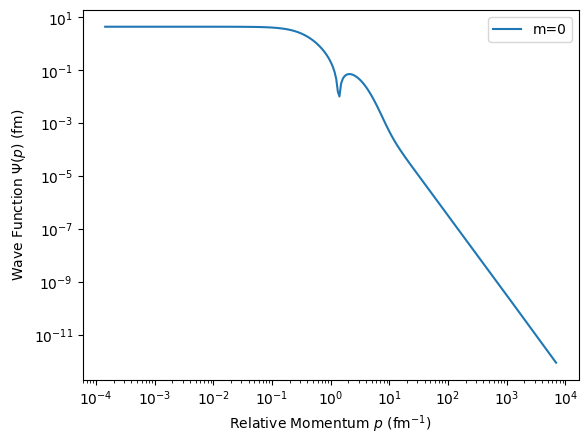

In [ ]:

# This code solves the Schrödinger equation for Deuteron in 2D
# with a Malfliet-Tjon (MT) potential.
# It calculates the binding energies and wave functions
# for different partial wave quantum numbers m_angular.

# Author: Mohammadreza Hadizadeh (mhadizadeh@centralstate.edu)
# February 2025.

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.special import roots_legendre
from scipy.sparse.linalg import eigs

# Constants
Np = 100
Nphi = 40
pi = np.pi
ONE = 1.0
ZERO = 0.0
Tol_lambda = 1.0e-10
hb2m = 41.47
hc = 197.32860
mass=1.0/hb2m  # [MeV^-1.fm^-2]
m_angular = 0  # Orbital quantum number
# MT potential parameters
Vr = 1438.72280 # MeV.fm
Mr = 3.21 # fm^-1
Va = -600.0 # MeV.fm
Ma = 1.550 # fm^-1
# 2B initial binding enenrgy guesses
BE2_1 = -10.0  # Lower bound for energy estimate
BE2_2 = -5.0  # Upper bound for energy estimate
# -----------------------
# Subroutines and Functions
# -----------------------
def hyperbolic(Np):
    """
    Generate hyperbolic distribution points and their weights using Legendre roots.
    Returns:
        (P, dP): Tuple of numpy arrays of shape (Np,)
                 P is the transformed momentum points
                 dP is the corresponding weights
    """
    X, dX = roots_legendre(Np)
    P = (1.0 + X) / (1.0 - X)
    dP = 2.0 / (1.0 - X)**2 * dX
    return P, dP

def linear(Nphi, a, b):
    """
    Generate linear distribution points and their weights for variables over an interval [a, b].
    Args:
        Nphi (int): Number of points in phi.
        a (float): Start of the interval.
        b (float): End of the interval.

    Returns:
        (x, dx): Tuple of numpy arrays of shape (Nphi,)
                 x is the linearly mapped points from [-1, 1] to [a, b]
                 dx is the corresponding weights
    """
    X, dX = roots_legendre(Nphi)
    x = (b - a) / 2 * X + (b + a) / 2
    dx = (b - a) / 2 * dX
    return x, dx

def eigenvalue(Mmatrix):
    """
    This function calculates a few eigenvalues and eigenvectors of the matrix Mmatrix.

    Args:
        Mmatrix (numpy.ndarray): A square matrix from which to find eigenvalues and eigenvectors.

    Returns:
        WF (numpy.ndarray): The eigenvectors corresponding to the largest eigenvalue.
        Lambda (float): The largest eigenvalue.
    """
    # Determine the size of the matrix
    dim_Mmatrix = Mmatrix.shape[0]

    # Specify the number of eigenvalues and eigenvectors to find
    # NEV: number of eigenvalues,
    # NCV: number of Arnoldi vectors, must be greater than NEV
    NEV = 10
    NCV = 2 * NEV # A larger NCV can accelerate convergence
    # Use 'LM' (Largest Magnitude) or 'LR' (Largest Real part) as needed
    WHICH = 'LR'
    # Find NEV eigenvalues with the largest magnitude
    eigenvalues, eigenvectors = eigs(Mmatrix, k=NEV, which=WHICH, ncv=NCV)
    # Target eigenvalue near 1
    target_eigenvalue = 1.0
    idx_min = np.argmin(np.abs(eigenvalues - target_eigenvalue))
    Lambda = eigenvalues[idx_min]
    WF = np.abs(eigenvectors[:, idx_min])

    return WF, Lambda

def compute_V_2B(Np, Nphi, m_angular, p, xp, phi, dphi):
    """
    Computes the 3D array V_2B (for potential calculations) and integrates it
    over phi to form a 2D array V_2B_2d.

    Args:
        Np (int): Number of p points
        Nphi (int): Number of phi points
        m_angular: state quantum number
        p (np.ndarray): 1D array of momentum values of length Np
        xp (np.ndarray): 1D array of cos(phi) values of length Nphi
        dphi (np.ndarray): 1D array of differential phi weights of length Nphi

    Returns:
        V_2B_2d (np.ndarray): 2D array of shape (Np, Np), the integrated potential over phi
    """
    # Initialize the V_2B 3D array
    V_2B = np.zeros((Np, Np, Nphi))

    # Populate the V_2B array
    for ip in range(Np):
        for ipp in range(Np):
            for ixp in range(Nphi):
                q = np.sqrt(p[ip]**2 + p[ipp]**2
                            - 2.0 * p[ip] * p[ipp] * xp[ixp])
                V_2B[ip, ipp, ixp] =  1.0 / (2.0 * pi) * (Vr / np.sqrt(q**2 + Mr**2) + Va / np.sqrt(q**2 + Ma**2))

    # Integrate V_2B over phi to produce V_2B_2d
    V_2B_2d = np.zeros((Np, Np))
    cos_terms = np.cos(m_angular * phi)  # This computes the cosine term for all phi values

    for ipp in range(Np):
        for ip in range(Np):
          # phi integration
           V_2B_2d[ip, ipp] = np.sum(dphi * V_2B[ip, ipp, :] * cos_terms)

    return V_2B_2d

def LS_2D(Np, pp, dp, V_NR, BE2_1, BE2_2):
    """
    Demonstration routine for computing eigenvalues using the 2D LS approach.

    Args:
        Np (int): Number of momentum points
        pp (np.ndarray): Momentum array of shape (Np,)
        dp (np.ndarray): Weights array associated with pp
        V_NR (np.ndarray): 2D potential array V_NR of shape (Np, Np)

    Returns:
        (BE2, WF): Tuple of (float, np.ndarray)
                   BE2 is the last computed energy
                   WF is the corresponding wave function array of shape (Np,)
    """
    Ne = 20
    BE_ary = np.zeros(Ne)
    Lam_ary = np.zeros(Ne)
    BE_ary[0] = BE2_1
    BE_ary[1] = BE2_2

    for ie in range(Ne):
        # Extrapolation-like step if needed:
        if ie > 1:
            BE_ary[ie] = (BE_ary[ie-1]
                          + (1 - Lam_ary[ie-1])/(Lam_ary[ie-2] - Lam_ary[ie-1])
                          * (BE_ary[ie-2] - BE_ary[ie-1]))
        BE2 = BE_ary[ie]

        # Build the matrix
        Mmatrix = np.zeros((Np, Np))
        for ip in range(Np):
            for ipp in range(Np):
                denom = (BE2 - pp[ip]**2 / mass)
                if denom != 0:
                    Mmatrix[ip, ipp] = (dp[ipp] * pp[ipp] * V_NR[ip, ipp] / denom)

        WF, Lambda = eigenvalue(Mmatrix)
        # Normalize WF
        WF /= np.sqrt(np.sum(WF**2 * dp * pp))

        Lam_ary[ie] = np.real(Lambda)
        print(f"Search {ie+1} | BE2 = {BE2} MeV, Lambda = {Lambda}")

        if np.abs(Lambda - 1.0) < Tol_lambda:
            break

    return BE2, WF

# -----------------------
# Main Program
# -----------------------
def main():
    p, dp = hyperbolic(Np)
    phi, dphi = linear(Nphi, 0, 2.0 * pi)
    xp = np.cos(phi)
    WF_matrix = []

    # Loop over values of n from 0 up to m_angular
    for n in range(0, m_angular+1):
        V_2B_2d = compute_V_2B(Np, Nphi, n, p, xp, phi, dphi)
        BE2, WF = LS_2D(Np, p, dp, V_2B_2d, BE2_1, BE2_2)
        WF_matrix.append(WF)

        print('')
        print(f'Computed Energy (MeV): {BE2}')

        plt.loglog(p, WF, label=f'm={m_angular}')
        plt.xlabel(r'Relative Momentum $p$ (fm$^{-1}$)')
        plt.ylabel(r'Wave Function $\Psi(p)$ (fm)')
        plt.legend()
        plt.show()

if __name__ == "__main__":
    main()